# Google Advanced Data Analytics Capstone: Analyzing Employee Churn Risk

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor, plot_importance

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,\
accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV

import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('HR_capstone_dataset.csv')

In [3]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [6]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [4]:
df = df.rename(columns = {
        'Work_accident': 'work_accident',
        'average_montly_hours': 'average_monthly_hours',
        'time_spend_company': 'tenure',
        'Department': 'department'
    })

In [9]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [10]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [12]:
df.duplicated().sum()

np.int64(3008)

In [5]:
df1 = df.drop_duplicates(keep = 'first').reset_index(drop = True)

In [7]:
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Check outlies

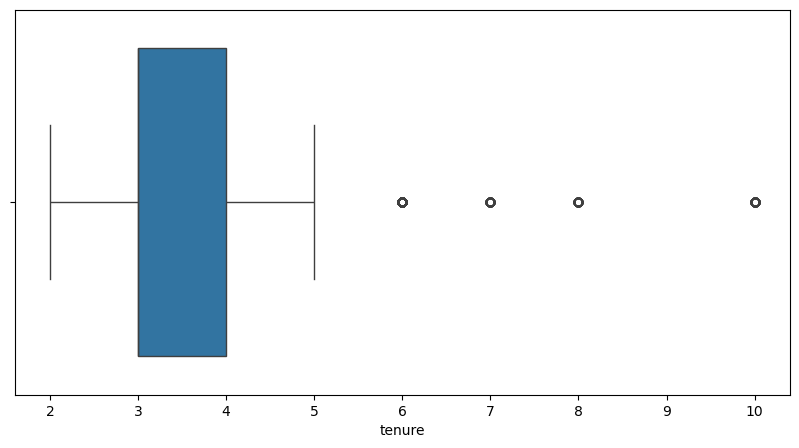

In [21]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = df1['tenure']);

In [6]:
# iqr = q3 - q1
# upper outliers = q3 + (1.5 * iqr)
# lower outliers = q1 - (1.5 * iqr)
q3 = df1['tenure'].quantile(0.75)
q1 = df1['tenure'].quantile(0.25)
iqr = q3 - q1

upper_outliers = q3 + (1.5 * iqr)
lower_outliers = q1 - (1.5 * iqr)

In [7]:
outliers = df1[(df1['tenure'] < lower_outliers) | (df1['tenure'] > upper_outliers)]

In [31]:
outliers.shape

(824, 10)

In [33]:
df1['left'].value_counts()

left
0    10000
1     1991
Name: count, dtype: int64

In [35]:
df1['left'].value_counts(normalize = True) * 100

left
0    83.39588
1    16.60412
Name: proportion, dtype: float64

In [10]:
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Data Visualizations

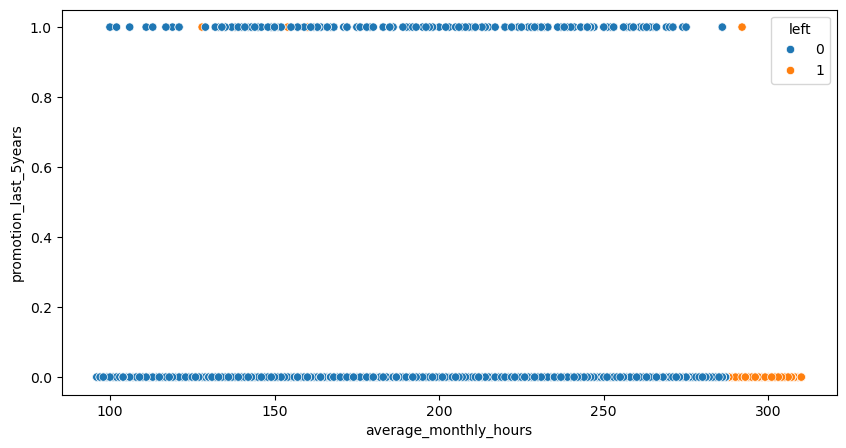

In [ ]:
plt.figure(figsize = (10, 5))
sns.scatterplot(data = df1, x = 'average_monthly_hours', y = 'promotion_last_5years', hue = 'left');

Text(0.5, 1.0, 'Count of left by department')

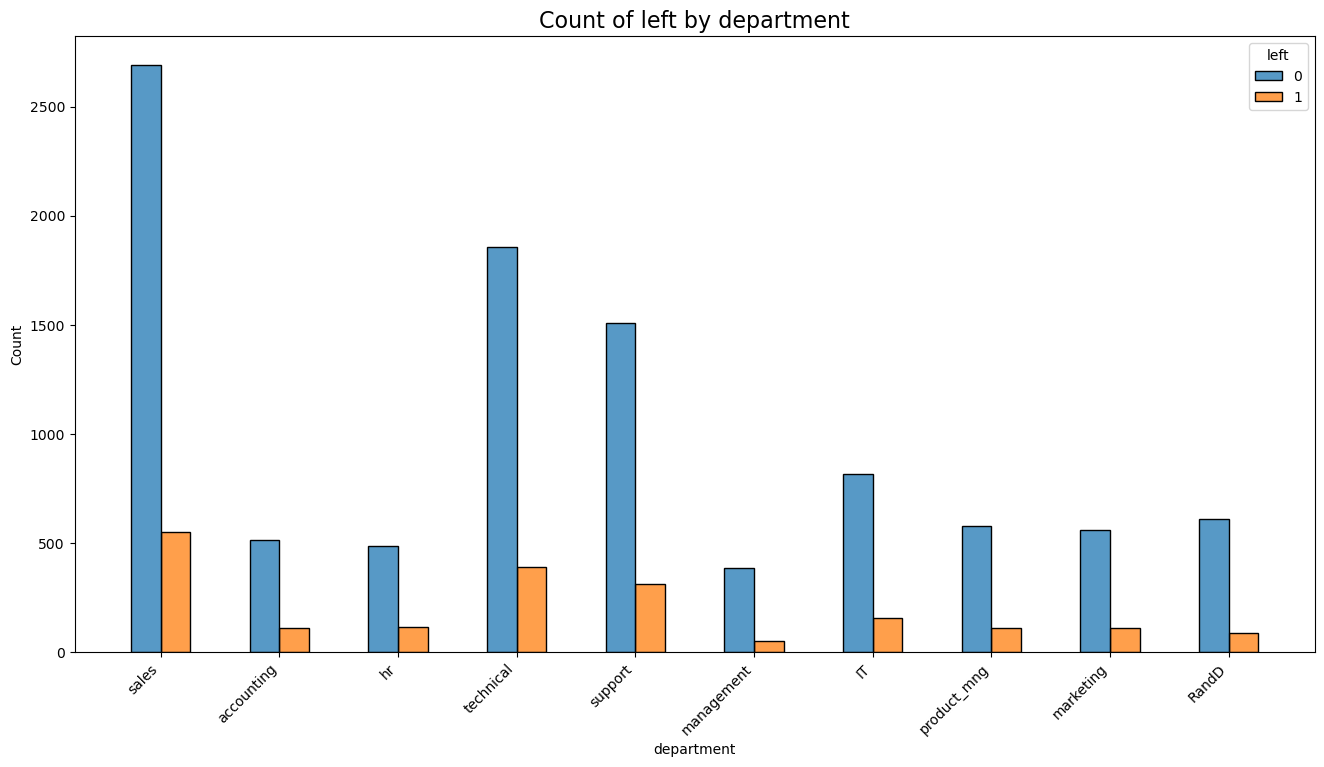

In [53]:
plt.figure(figsize = (16, 8))
sns.histplot(data = df1, x = 'department', hue = 'left', multiple = 'dodge', shrink = 0.5)
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.title('Count of left by department', fontsize = 16)

<Axes: xlabel='number_project', ylabel='Count'>

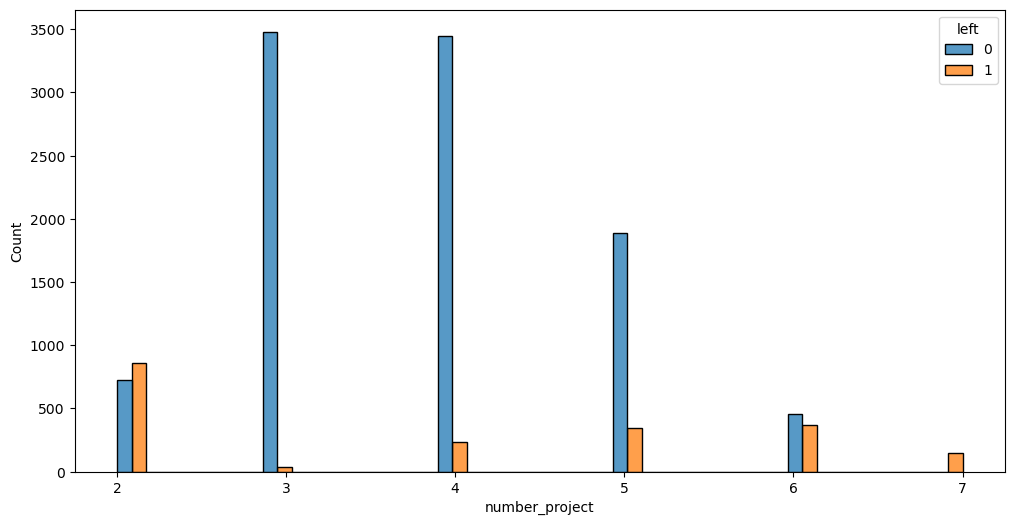

In [67]:
plt.figure(figsize = (12, 6))
sns.histplot(x = df1['number_project'], hue = df1['left'], multiple = 'dodge')

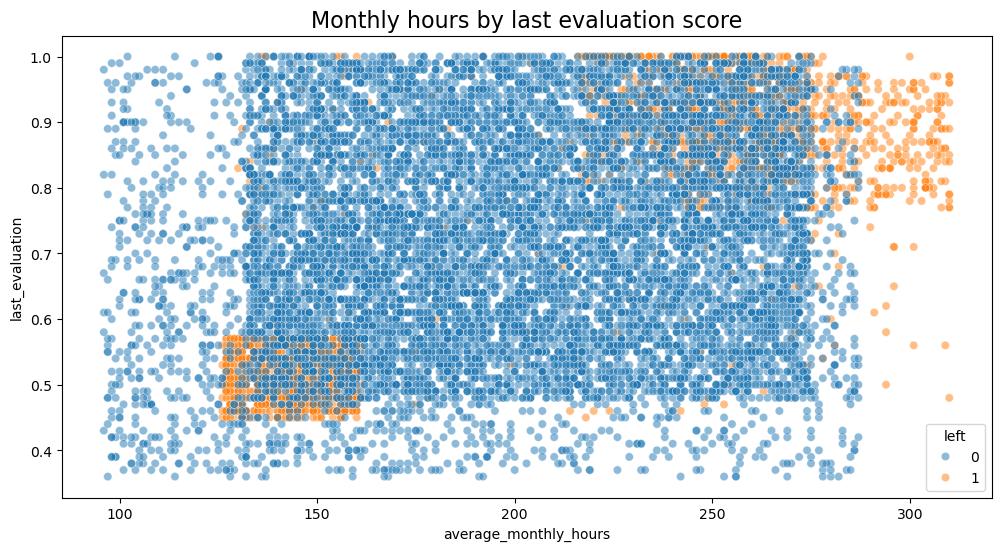

In [76]:
plt.figure(figsize = (12, 6))
sns.scatterplot(data = df1, x = 'average_monthly_hours', y = 'last_evaluation', hue = 'left', alpha = 0.5)
plt.title('Monthly hours by last evaluation score', fontsize = 16);

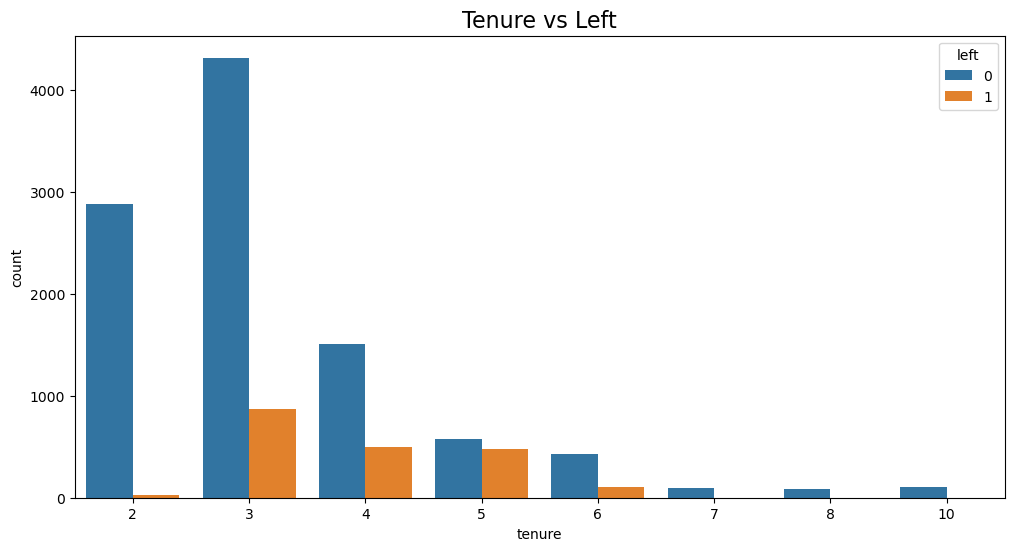

In [83]:
plt.figure(figsize = (12, 6))
sns.countplot(data = df1, x = 'tenure', hue = 'left')
plt.title('Tenure vs Left', fontsize = 16);

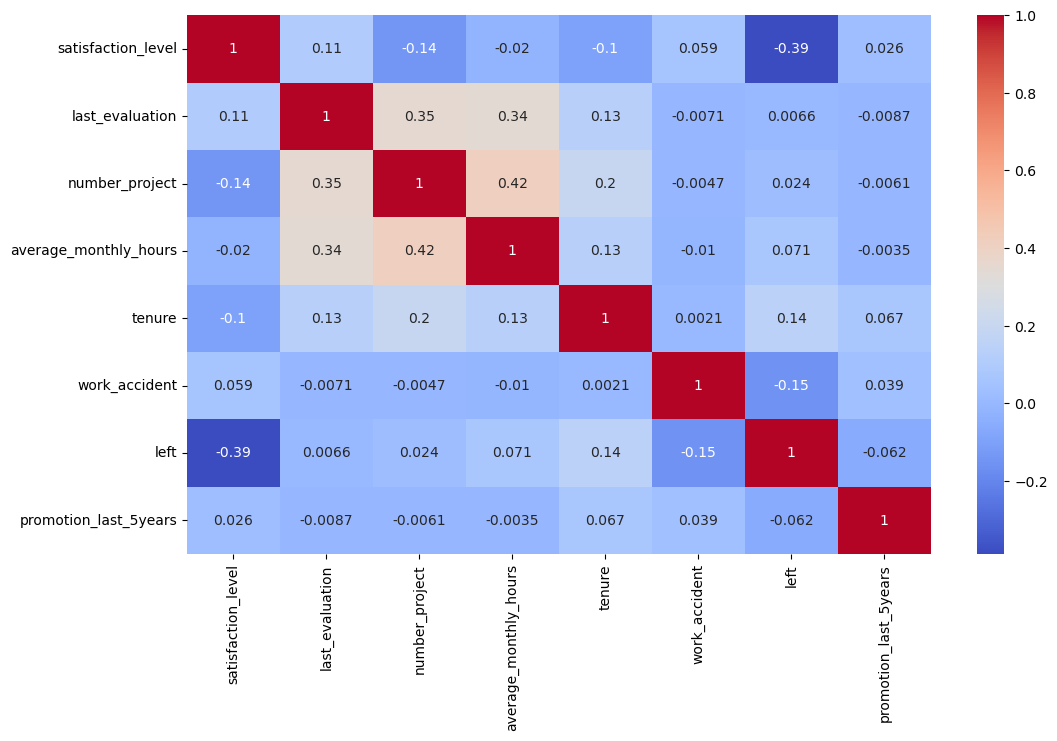

In [93]:
plt.figure(figsize = (12,7))
sns.heatmap(data = df.corr(numeric_only=True), annot = True, cmap = 'coolwarm');

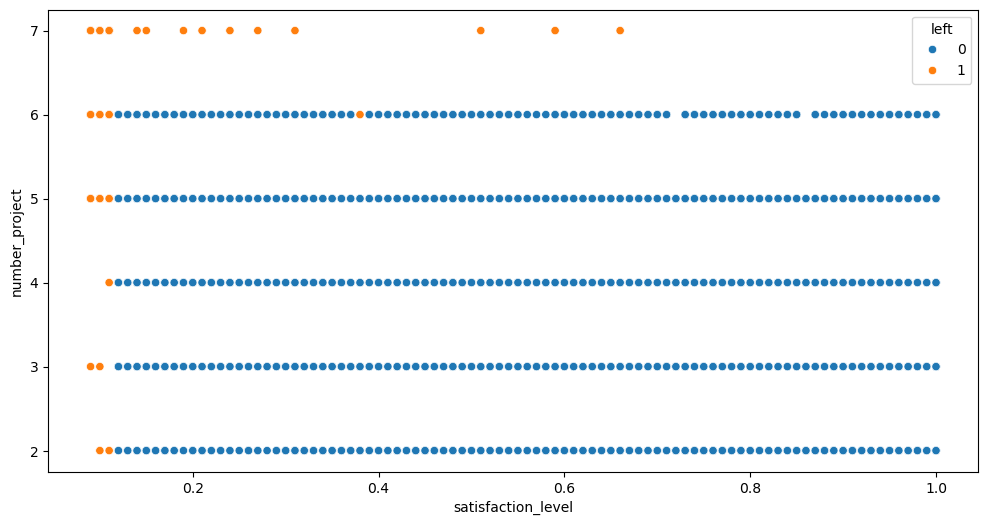

In [11]:
plt.figure(figsize = (12, 6))
sns.scatterplot(data = df1, x = 'satisfaction_level', y = 'number_project', hue = 'left');

## Logistic Regression

In [12]:
df1['salary'] = df1['salary'].map({'low': 0, 'medium': 1, 'high': 2})

In [12]:
df1.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_monthly_hours      int64
tenure                     int64
work_accident              int64
left                       int64
promotion_last_5years      int64
department                object
salary                     int64
dtype: object

In [13]:
df_get_dummies = pd.get_dummies(df1, columns = ['department'], drop_first = True)

In [50]:
df_get_dummies.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,True,False,False


In [14]:
df_logis = df_get_dummies[(df_get_dummies['tenure'] >= lower_outliers) & (df_get_dummies['tenure'] <= upper_outliers)].reset_index(drop = True)

In [15]:
y = df_logis['left']

X = df_logis.drop(['left'], axis = 1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 42)

In [17]:
log_reg = LogisticRegression(random_state = 42, max_iter = 500).fit(X_train, y_train)

In [18]:
y_pred = log_reg.predict(X_test)

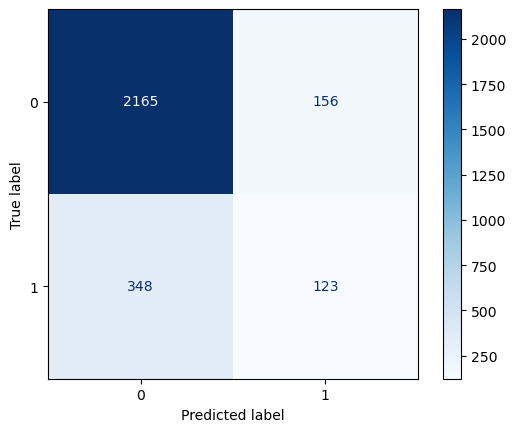

In [19]:
log_cm = confusion_matrix(y_test, y_pred, labels = log_reg.classes_)
log_disp = ConfusionMatrixDisplay(confusion_matrix = log_cm)

log_disp.plot(cmap = 'Blues')
plt.show()

In [20]:
print(classification_report(y_test, y_pred, target_names = ['stayed', 'left'] ))

              precision    recall  f1-score   support

      stayed       0.86      0.93      0.90      2321
        left       0.44      0.26      0.33       471

    accuracy                           0.82      2792
   macro avg       0.65      0.60      0.61      2792
weighted avg       0.79      0.82      0.80      2792



In [21]:
print(f'Accuracy: {accuracy_score(y_test, y_pred): .6f}')
print(f'Precision: {precision_score(y_test, y_pred): .6f}')
print(f'Recall: {recall_score(y_test, y_pred): .6f}')
print(f'F1 score: {f1_score(y_test, y_pred): .6f}')

Accuracy:  0.819484
Precision:  0.440860
Recall:  0.261146
F1 score:  0.328000


## Tree-based Model

### Decision tree

In [22]:
tree = DecisionTreeClassifier(random_state = 42)

cv_params = {
    'max_depth': [4, 6, 8, 10, 12, None],
    'min_samples_leaf': [1, 2, 5],     
    'min_samples_split': [2, 4, 6]
}

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

de_tree = GridSearchCV(tree, cv_params, scoring = scoring, cv = 4, refit = 'roc_auc')

In [23]:
de_tree.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8, 10, 12, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [24]:
de_tree.best_params_

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [25]:
de_tree.best_score_

np.float64(0.9738070859906354)

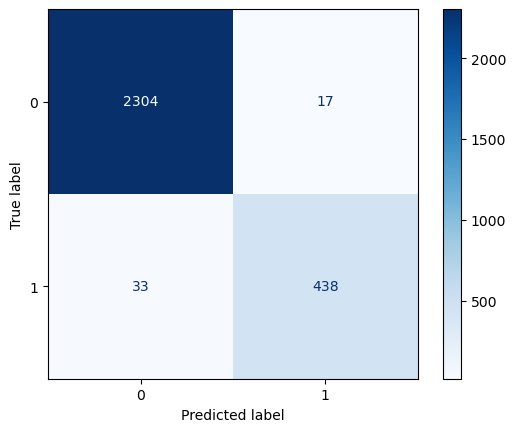

In [26]:
dt_pred = de_tree.best_estimator_.predict(X_test)
dt_cm = confusion_matrix(y_test, dt_pred, labels = de_tree.classes_)
dt_disp = ConfusionMatrixDisplay(confusion_matrix = dt_cm)
dt_disp.plot(cmap = 'Blues')
plt.show()

In [27]:
def make_results(model_name, model_object, metric):
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }
    
    cv_results = pd.DataFrame(model_object.cv_results_)

    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [28]:
de_tree_reuslts = make_results('Decision tree', de_tree, 'auc')
de_tree_reuslts

,model,precision,recall,F1,accuracy,auc
0,Decision tree,0.959115,0.912839,0.935275,0.978747,0.973807


In [29]:
def get_scores(model_name, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''
    pred = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, pred)
    accuracy = accuracy_score(y_test_data, pred)
    precision = precision_score(y_test_data, pred)
    recall = recall_score(y_test_data, pred)
    f1 = f1_score(y_test_data, pred)

    table = pd.DataFrame({
        'model': [model_name],
        'precision': [precision],
        'recall': [recall],
        'f1': [f1],
        'accuracy': [accuracy],
        'AUC': [auc]
    })

    return table

In [30]:
dt_test_scores = get_scores('Decision tree test set', de_tree, X_test, y_test)

In [31]:
dt_test_scores

,model,precision,recall,f1,accuracy,AUC
0,Decision tree test set,0.962637,0.929936,0.946004,0.982092,0.961306


### Random forest

In [34]:
rf = RandomForestClassifier(random_state = 42)

cv_params = {
    'n_estimators': [300, 500],
    'max_depth': [3, 5, None],
    'max_features': [1.0],
    'max_samples': [0.7, 1.0] ,
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
}

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

ran_f = GridSearchCV(rf, cv_params, scoring = scoring, cv = 4, refit = 'roc_auc')

In [35]:
ran_f.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [36]:
rf_pred = ran_f.predict(X_test)

In [37]:
ran_f.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [38]:
ran_f.best_score_

np.float64(0.9809373749824897)

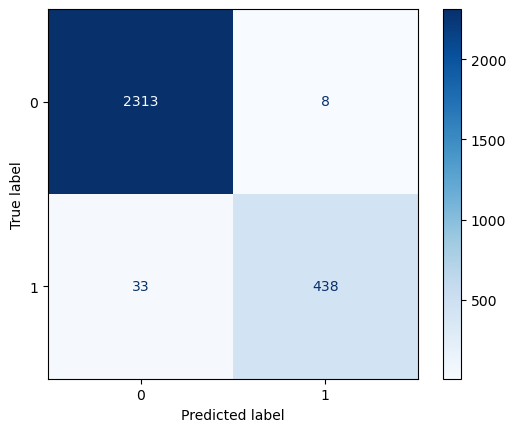

In [39]:
rf_pred = ran_f.best_estimator_.predict(X_test)
rf_cm = confusion_matrix(y_test, rf_pred, labels = ran_f.classes_)
rf_disp = ConfusionMatrixDisplay(confusion_matrix = rf_cm)
rf_disp.plot(cmap = 'Blues')
plt.show()

In [40]:
rf_results = make_results('Random Forest', ran_f, 'auc')
rf_results

,model,precision,recall,F1,accuracy,auc
0,Random Forest,0.968239,0.908588,0.937349,0.979583,0.980937


In [41]:
pd.concat([de_tree_reuslts, rf_results])

,model,precision,recall,F1,accuracy,auc
0,Decision tree,0.959115,0.912839,0.935275,0.978747,0.973807
0,Random Forest,0.968239,0.908588,0.937349,0.979583,0.980937


In [42]:
rf_test_scores = get_scores('Random forest test set', ran_f, X_test, y_test)

In [43]:
rf_test_scores

,model,precision,recall,f1,accuracy,AUC
0,Random forest test set,0.982063,0.929936,0.955289,0.985315,0.963245


In [44]:
pd.concat([dt_test_scores, rf_test_scores])

,model,precision,recall,f1,accuracy,AUC
0,Decision tree test set,0.962637,0.929936,0.946004,0.982092,0.961306
0,Random forest test set,0.982063,0.929936,0.955289,0.985315,0.963245


## Save model

In [ ]:
path = '../Your-File-Path/'

In [46]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [47]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [49]:
write_pickle(path, ran_f, 'hr_random_forest')

## Feature Engineering

In [52]:
df2 = df_get_dummies.drop('satisfaction_level', axis = 1)

In [55]:
df2['hour_per_project'] = df['average_monthly_hours'] / df2['number_project']
df2['burnout_index'] = df2['last_evaluation'] * df2['average_monthly_hours']

In [56]:
df2.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,hour_per_project,burnout_index
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,True,False,False,78.500000,83.21
1,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,True,False,False,52.400000,225.32
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,True,False,False,38.857143,239.36
3,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,True,False,False,44.600000,194.01
4,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,True,False,False,79.500000,82.68


## Decision Tree After Feature Engineering

In [57]:
y = df2['left']

X = df2.drop(['left'], axis = 1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 42)

In [ ]:
tree = DecisionTreeClassifier(random_state = 42)

cv_params = {
    'max_depth': [4, 6, 8, None],
    'min_samples_leaf': [2, 5, 1],
    'min_samples_split': [2, 4, 6]
}

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

tree2 = GridSearchCV(tree, cv_params, scoring = scoring, cv = 4, refit = 'roc_auc')

In [64]:
tree2.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [65]:
tree2.best_params_

{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 6}

In [66]:
tree2.best_score_

np.float64(0.9670945659082546)

In [70]:
tree2_results = make_results('Decision tree 2', tree2, 'auc')
print(de_tree_reuslts)
print(tree2_results)

           model  precision    recall        F1  accuracy       auc
0  Decision tree   0.959115  0.912839  0.935275  0.978747  0.973807
             model  precision    recall        F1  accuracy       auc
0  Decision tree 2   0.899973  0.882785  0.891135  0.964195  0.967095


## Random Forest After Feature Engineering

In [72]:
rf = RandomForestClassifier(random_state = 42)

cv_params = {
    'n_estimators': [300, 500],
    'max_depth': [3, 5, None],
    'max_features': [1.0],
    'max_samples': [0.7, 1.0] ,
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
}

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

rf2 = GridSearchCV(rf, cv_params, scoring = scoring, cv = 4, refit = 'roc_auc')

In [73]:
rf2.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [74]:
write_pickle(path, rf2, 'hr_rf_2')

In [75]:
rf2.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 300}

In [76]:
rf2.best_score_

np.float64(0.9765051507027377)

In [79]:
rf2_results = make_results('Random Forest 2', rf2, 'auc')
print(tree2_results)
print(rf2_results)

             model  precision    recall        F1  accuracy       auc
0  Decision tree 2   0.899973  0.882785  0.891135  0.964195  0.967095
             model  precision    recall       F1  accuracy       auc
0  Random Forest 2   0.930517  0.895514  0.91259  0.971533  0.976505


In [84]:
rf2_test_scores = get_scores('Random forest 2 test set', rf2, X_test, y_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,Random forest 2 test set,0.940678,0.891566,0.915464,0.972648,0.940183


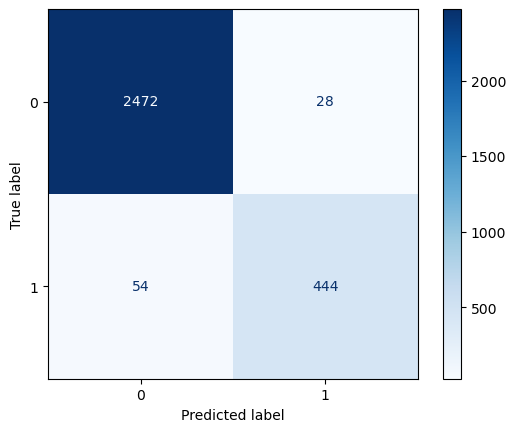

In [85]:
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels = rf2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf2.classes_)

disp.plot(cmap = 'Blues');

## Feature Importance

### Before Feature Engineering

In [70]:
dct_imp = pd.DataFrame(de_tree.best_estimator_.feature_importances_, columns = ['gini_importance'], index = X.columns)
dct_imp = dct_imp.sort_values(['gini_importance'], ascending = False)
dct_imp

,gini_importance
satisfaction_level,0.553990
tenure,0.167601
last_evaluation,0.138160
number_project,0.114046
average_monthly_hours,0.026202
work_accident,0.000000
promotion_last_5years,0.000000
salary,0.000000
department_RandD,0.000000
department_accounting,0.000000


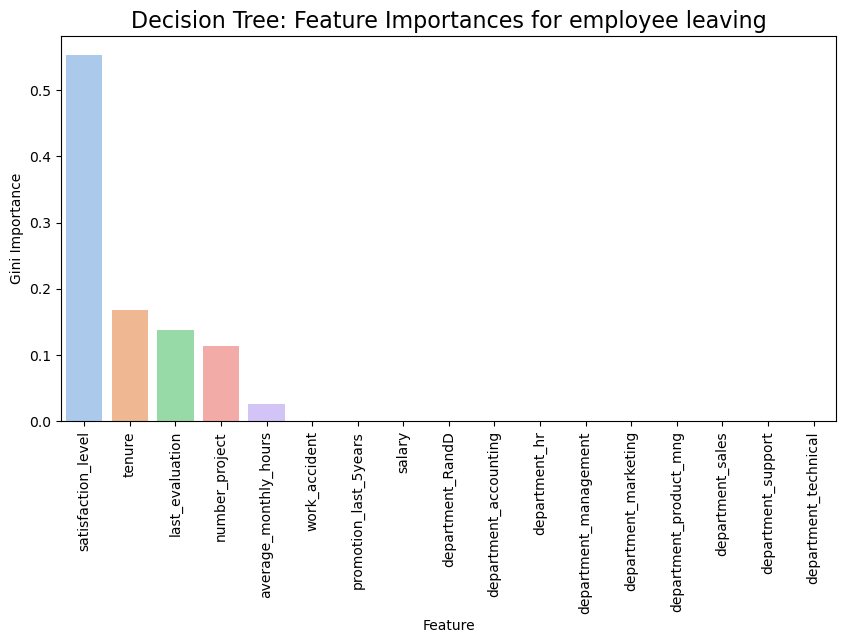

In [102]:
plt.figure(figsize = (10, 5))
sns.barplot(data = dct_imp, x = dct_imp.index, y = 'gini_importance', palette = 'pastel')
plt.xticks(rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Gini Importance')
plt.title('Decision Tree: Feature Importances for employee leaving', fontsize = 16)
plt.show()

In [79]:
rf_imp = pd.DataFrame(ran_f.best_estimator_.feature_importances_, columns = ['gini_importance'], index = X.columns)
rf_imp = rf_imp.sort_values(['gini_importance'], ascending = False)
rf_imp

,gini_importance
satisfaction_level,0.353157
number_project,0.196000
tenure,0.172419
average_monthly_hours,0.145502
last_evaluation,0.111383
work_accident,0.007210
salary,0.005772
department_sales,0.001733
department_support,0.001519
department_technical,0.001517


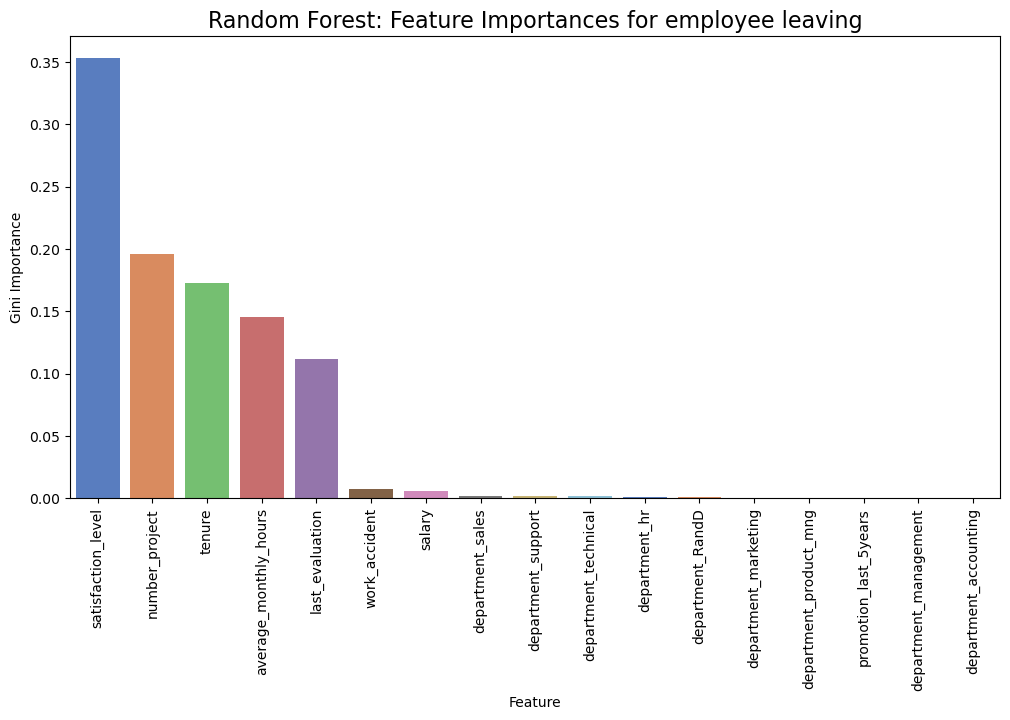

In [103]:
plt.figure(figsize = (12, 6))
sns.barplot(data = rf_imp, x = rf_imp.index, y = 'gini_importance', palette = 'muted')
plt.xticks(rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Gini Importance')
plt.title('Random Forest: Feature Importances for employee leaving', fontsize = 16)
plt.show()

### After Feature Engineering

In [88]:
tree2_imp = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns = ['gini_importance'], index = X.columns)
tree2_imp = tree2_imp.sort_values(['gini_importance'], ascending = False)
tree2_imp

,gini_importance
burnout_index,0.378086
number_project,0.266256
tenure,0.242540
average_monthly_hours,0.061115
last_evaluation,0.041072
hour_per_project,0.007587
department_management,0.001585
department_marketing,0.000844
department_sales,0.000701
department_technical,0.000214


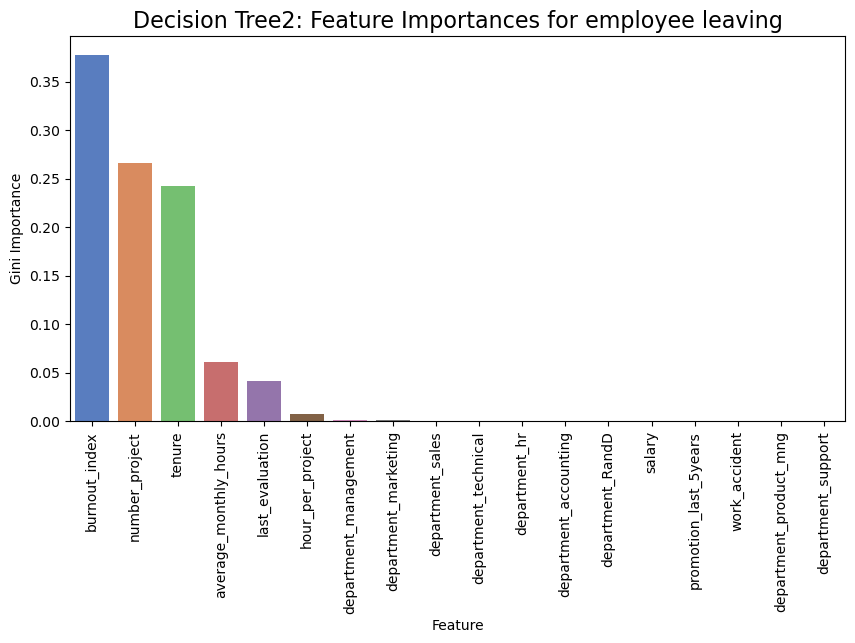

In [89]:
plt.figure(figsize = (10, 5))
sns.barplot(data = tree2_imp, x = tree2_imp.index, y = 'gini_importance', palette = 'muted')
plt.xticks(rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Gini Importance')
plt.title('Decision Tree2: Feature Importances for employee leaving', fontsize = 16)
plt.show()

In [90]:
rf2_imp = pd.DataFrame(rf2.best_estimator_.feature_importances_, columns = ['gini_importance'], index = X.columns)
rf2_imp = rf2_imp.sort_values(['gini_importance'], ascending = False)
rf2_imp

,gini_importance
burnout_index,0.345513
number_project,0.232275
tenure,0.219774
average_monthly_hours,0.075621
last_evaluation,0.052159
hour_per_project,0.043391
salary,0.008479
work_accident,0.004725
department_support,0.002855
department_technical,0.002829


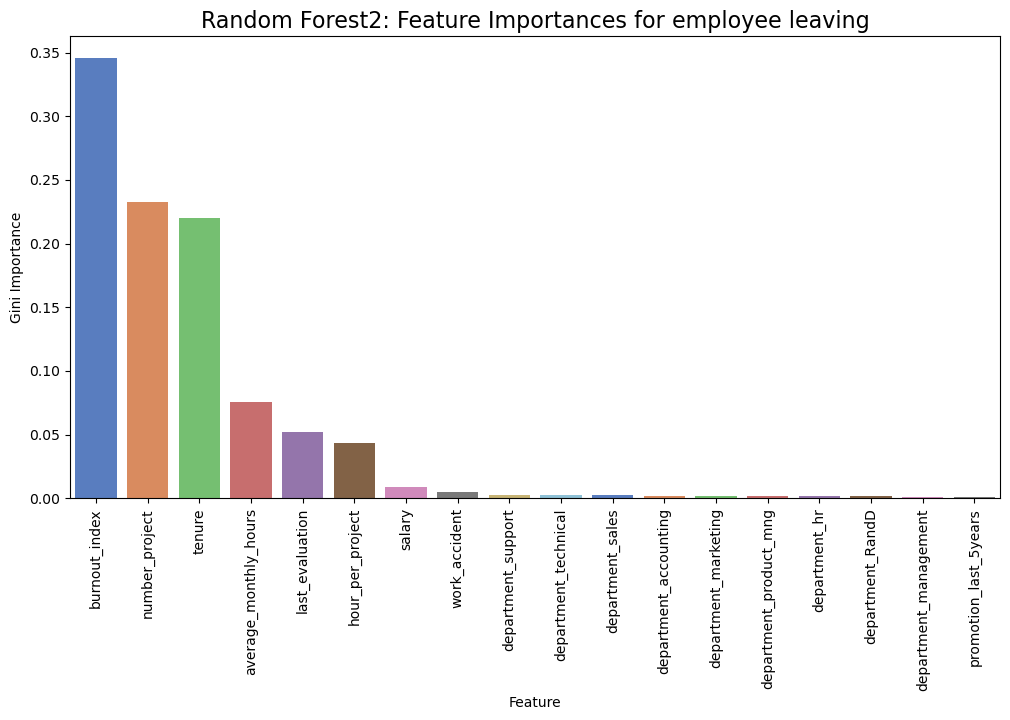

In [91]:
plt.figure(figsize = (12, 6))
sns.barplot(data = rf2_imp, x = rf2_imp.index, y = 'gini_importance', palette = 'muted')
plt.xticks(rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Gini Importance')
plt.title('Random Forest2: Feature Importances for employee leaving', fontsize = 16)
plt.show()